In [1]:
from pyluos import Robot
from spherical_joint import Actuator
import time
import math
import numpy as np
import threading

In [2]:
r = Robot('/dev/cu.usbserial-DN05NM15')
print(r.modules)

Connected to "/dev/cu.usbserial-DN05NM15".
Sending detection signal.
Waiting for route table...
Robot setup.
-------------------------------------------------
Type                Alias               ID   
-------------------------------------------------
Gate                gate                1    
Voltage             analog_read_P1      2    
Voltage             analog_read_P7      3    
Voltage             analog_read_P8      4    
Voltage             analog_read_P9      5    
State               digit_read_P5       6    
State               digit_read_P6       7    
State               digit_write_P2      8    
State               digit_write_P3      9    
State               digit_write_P4      10   
ControlledMotor     disk_middle         11   
ControlledMotor     disk_bottom         12   
ControlledMotor     disk_top            13   



### Parameters of the actuator

In [3]:
R0 = [[math.cos(60*math.pi/180),-math.sin(60*math.pi/180),0],[math.sin(60*math.pi/180),math.cos(60*math.pi/180),0],[0,0,1]]
a = Actuator([0,0,93],[0,0,73],33.5,R0)

#r.gate.delay=10
r.disk_bottom.rot_position=False
r.disk_middle.rot_position=False
r.disk_top.rot_position=False

###########Setup############

r.disk_bottom.encoder_res = 5
r.disk_middle.encoder_res = 5
r.disk_top.encoder_res = 5


r.disk_bottom.setToZero()
r.disk_middle.setToZero()
r.disk_top.setToZero()


r.disk_bottom.reduction = 77.35
r.disk_middle.reduction = 77.35
r.disk_top.reduction = 77.35

r.disk_bottom.limit_current = 0.8
r.disk_middle.limit_current = 0.8
r.disk_top.limit_current = 0.8

r.disk_bottom.wheel_size = 62
r.disk_middle.wheel_size = 62
r.disk_top.wheel_size = 62

r.disk_bottom.positionPid = [16,0.04,100.0]
r.disk_middle.positionPid = [16,0.04,100.0]
r.disk_top.positionPid = [16,0.04,100.0]

r.disk_middle.speedPid = [0,0.25,0.5]
r.disk_top.speedPid = [0,0.25,0.5]
r.disk_bottom.speedPid = [0,0.25,0.5]

r.disk_bottom.rot_position_mode = True
r.disk_middle.rot_position_mode = True
r.disk_top.rot_position_mode = True

r.disk_top.rot_position = True
r.disk_middle.rot_position = True
r.disk_bottom.rot_position = True

r.disk_top.rot_speed = True
r.disk_middle.rot_speed = True
r.disk_bottom.rot_speed = True


In [4]:
#If speed must be limited

r.disk_bottom.rot_speed_mode = False
r.disk_middle.rot_speed_mode = False
r.disk_top.rot_speed_mode = False

#r.disk_bottom.target_rot_speed = 100
#r.disk_middle.target_rot_speed = 100
#r.disk_top.target_rot_speed = 100

### Compliant Mode

In [20]:
r.disk_bottom.compliant = True
r.disk_middle.compliant = True
r.disk_top.compliant = True

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fd86d08>, {'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166e88c8>, {'parameters': 401})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166e87b8>, {'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fd86d08>, {'parameters': 401})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166e8950>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fd86d08>, {'parameters': 401})})


In [4]:
r.disk_bottom.compliant = False
r.disk_middle.compliant = False
r.disk_top.compliant = False

### Finds zero with a stop screw

In [14]:
def zero3(): ###Pratique sans la tête
    r.disk_bottom.power_mode = True
    r.disk_middle.power_mode = True
    r.disk_top.power_mode = True

    r.disk_bottom.power_ratio = 0
    r.disk_middle.power_ratio = 0
    r.disk_top.power_ratio = 0

        #Bottom disk zero

    r.disk_bottom.compliant = False
    r.disk_middle.compliant = False
    r.disk_top.compliant = False

    r.disk_bottom.power_ratio = -60
    r.disk_middle.power_ratio = -60
    r.disk_top.power_ratio = -60

    
    time.sleep(1)

    r.disk_bottom.power_ratio = 0
    r.disk_middle.power_ratio = 0
    r.disk_top.power_ratio = 0
    
    r.disk_bottom.setToZero()
    r.disk_middle.setToZero()
    r.disk_top.setToZero()
    
    time.sleep(0.1)
    r.disk_bottom.rot_position_mode = True
    r.disk_middle.rot_position_mode = True
    r.disk_top.rot_position_mode = True

    r.disk_bottom.target_rot_position = 125
    r.disk_middle.target_rot_position = 45+125
    r.disk_top.target_rot_position = 90+125

    time.sleep(0.5)
    
    r.disk_bottom.setToZero()
    r.disk_middle.setToZero()
    r.disk_top.setToZero()
    
    time.sleep(0.1)
    
    q11,q12,q13 = a.get_angles_from_vector([0,0,1],0)
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13

In [ ]:
zero3()

### Zeros with buttons

In [ ]:
angle = 0

value_top = 0
value_middle = 0
value_bottom = 0

bottom_zero_set = False
middle_zero_set = False
top_zero_set = False


while (bottom_zero_set == False or middle_zero_set == False or top_zero_set == False):
    value_top = r.analog_read_P9.volt
    value_middle = r.analog_read_P8.volt
    value_bottom = r.analog_read_P7.volt
    
    if top_zero_set == False:
        r.disk_top.target_rot_position = -angle
    if middle_zero_set == False:
        r.disk_middle.target_rot_position = -angle
    if bottom_zero_set == False:
        r.disk_bottom.target_rot_position = -angle

    if (value_top > 3 and top_zero_set == False):
        r.disk_top.setToZero()
        time.sleep(0.1)
        top_zero_set = True
        r.disk_top.target_rot_position = 0

    if (value_middle > 3 and middle_zero_set == False):
        r.disk_middle.setToZero()
        time.sleep(0.1)
        middle_zero_set = True
        r.disk_middle.target_rot_position = 0

    if (value_bottom > 3 and bottom_zero_set == False):
        r.disk_bottom.setToZero()
        time.sleep(0.1)
        bottom_zero_set = True
        r.disk_bottom.target_rot_position = 0

    time.sleep(0.01)
    angle+=0.2

time.sleep(1)

r.disk_top.target_rot_position = 0
r.disk_middle.target_rot_position = 0
r.disk_bottom.target_rot_position = 0


### Initial position

In [ ]:
r.disk_bottom.target_rot_position = 0
r.disk_middle.target_rot_position = 0
r.disk_top.target_rot_position = 0

In [ ]:
q11,q12,q13 = a.get_angles_from_vector([0,0,1],0)
r.disk_top.target_rot_position = -q11
r.disk_middle.target_rot_position = -q12
r.disk_bottom.target_rot_position = -q13
print(q11,q12,q13)

In [6]:
print(r.disk_top.rot_position, r.disk_middle.rot_position, r.disk_bottom.rot_position)

0.0 0.0 0.0


## Demo 0

#### Def Minjerk

In [6]:
def minjerk(initial_position, goal_position, duration):
    initial_velocity=0
    final_velocity=0
    initial_acceleration=0
    final_acceleration=0
    
    a0 = initial_position
    a1 = initial_velocity
    a2 = initial_acceleration / 2

    d1, d2, d3, d4, d5 = [duration ** i for i in range(1, 6)]

    A = np.array((
        (d3, d4, d5),
        (3 * d2, 4 * d3, 5 * d4),
        (6 * d1, 12 * d2, 20 * d3)
    ))
    B = np.array((
        goal_position - a0 - (a1 * d1) - (a2 * d2),
        final_velocity - a1 - (2 * a2 * d1),
        final_acceleration - (2 * a2)
    ))
    X = np.linalg.solve(A, B)

    coeffs = [
            a0,
            a1,
            a2,
            X[0],
            X[1],
            X[2]
    ]

    return lambda t: np.sum([
        c * t ** i
        for i, c in enumerate(coeffs)
    ], axis=0)

#### 4 points of view

In [16]:
dur = 1
r.disk_bottom.sampling_freq = 100

q1, q2, q3 = a.get_angles_from_vector([0,0,1],0)

q11, q12, q13 = a.get_angles_from_vector([-0.3, 0.3, 1], -45)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

Q1 = []
Q2 = []
Q3 = []

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    Q1.append(fq1(t))
    Q2.append(fq2(t))
    Q3.append(fq3(t))
    
    time.sleep(0.01)

r.disk_top.target_rot_position = Q1
r.disk_middle.target_rot_position = Q2
r.disk_bottom.target_rot_position = Q3

q1, q2, q3 = q11, q12, q13

#####

q11, q12, q13 = a.get_angles_from_vector([-0.3, -0.3, 1], 45)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

Q1 = []
Q2 = []
Q3 = []

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    Q1.append(fq1(t))
    Q2.append(fq2(t))
    Q3.append(fq3(t))
    
    time.sleep(0.01)

r.disk_top.target_rot_position = Q1
r.disk_middle.target_rot_position = Q2
r.disk_bottom.target_rot_position = Q3

q1, q2, q3 = q11, q12, q13

#####

q11, q12, q13 = a.get_angles_from_vector([0.1, 0.1, 1], 45)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

Q1 = []
Q2 = []
Q3 = []

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    Q1.append(fq1(t))
    Q2.append(fq2(t))
    Q3.append(fq3(t))
    
    time.sleep(0.01)

r.disk_top.target_rot_position = Q1
r.disk_middle.target_rot_position = Q2
r.disk_bottom.target_rot_position = Q3

q1, q2, q3 = q11, q12, q13

#####

q11, q12, q13 = a.get_angles_from_vector([0.1, -0.1, 1], -45)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

Q1 = []
Q2 = []
Q3 = []

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    Q1.append(fq1(t))
    Q2.append(fq2(t))
    Q3.append(fq3(t))
    
    time.sleep(0.01)

r.disk_top.target_rot_position = Q1
r.disk_middle.target_rot_position = Q2
r.disk_bottom.target_rot_position = Q3

q1, q2, q3 = q11, q12, q13

#####

q11, q12, q13 = a.get_angles_from_vector([0, 0, 1], 0)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

Q1 = []
Q2 = []
Q3 = []

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    Q1.append(fq1(t))
    Q2.append(fq2(t))
    Q3.append(fq3(t))
    
    time.sleep(0.01)

r.disk_top.target_rot_position = Q1
r.disk_middle.target_rot_position = Q2
r.disk_bottom.target_rot_position = Q3

q1, q2, q3 = q11, q12, q13

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x118e0d598>, {'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x118e0d2f0>, {'time': 0.01})})


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/augustin/dev/pyluos/pyluos/io/serial_io.py", line 89, in _poll
    to_read = self._serial.in_waiting
  File "/Users/augustin/.virtualenvs/spherical-joint/lib/python3.6/site-packages/serial/serialposix.py", line 467, in in_waiting
    s = fcntl.ioctl(self.fd, TIOCINQ, TIOCM_zero_str)
OSError: [Errno 6] Device not configured



In [24]:
dur = 1

q1, q2, q3 = a.get_angles_from_vector([0,0,1],0)

q11, q12, q13 = a.get_angles_from_vector([-0.3, 0.3, 1], -45)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
#time.sleep(2)
################

q11, q12, q13 = a.get_angles_from_vector([-0.3, -0.3, 1], 45)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    
#time.sleep(2)
################

q11, q12, q13 = a.get_angles_from_vector([0.1, 0.1, 1], 45)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    
#time.sleep(2)
################

q11, q12, q13 = a.get_angles_from_vector([0.1, -0.1, 1], -45)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    
#time.sleep(2)
################

q11, q12, q13 = a.get_angles_from_vector([0, 0, 1], 0)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    
#time.sleep(2)
################



defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 60.0}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 60.0}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 60.0}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 60.001}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 60.001})})
defaultdict(<fun

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501158>, {'target_rot_position': 61.7}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 63.885}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 62.793})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 61.942}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 64.438}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501158>, {'target_rot_position': 63.19})})
defaultdict

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 69.463}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 81.63}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 75.547})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501400>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 69.984}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 82.82}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 76.402})})
defaultdic

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501158>, {'target_rot_position': 80.183}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 106.134}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 93.158})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501400>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 80.69}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 107.293}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501158>, {'target_rot_position': 93.992})})
default

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 86.495}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 120.561}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 103.528})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 86.654}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 120.924}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 103.789})})
defa

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ad06158>, {'target_rot_position': 87.346}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 122.563}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 104.954})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ad06158>, {'target_rot_position': 87.284}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 122.502}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 104.893})})
defa

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ad06158>, {'target_rot_position': 79.812}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 115.03}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501158>, {'target_rot_position': 97.421})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ad06158>, {'target_rot_position': 78.845})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501598>, {'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ad06158>, {'target_rot_position': 114.063})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ad06158>, {'target_rot_position': 50.226}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 85.443}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 67.834})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ad06158>, {'target_rot_position': 48.372}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 83.59}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 65.981})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ad06158>, {'target_rot_position': -0.737}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 34.481}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 16.872})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ad06158>, {'target_rot_position': -1.125}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 34.092}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 16.484})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ace9c80>, {'target_rot_position': -2.566}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 32.566}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 15.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ace9c80>, {'target_rot_position': -2.54}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 32.54}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 15.0})})
defaultdict(<f

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ace9c80>, {'target_rot_position': -0.164}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 30.164}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 15.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ace9c80>, {'target_rot_position': 0.362}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501158>, {'target_rot_position': 29.638}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 15.0})})
defaultdict(<

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ace9c80>, {'target_rot_position': 15.299}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 14.701}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 15.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ace9c80>, {'target_rot_position': 15.635}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 14.365}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 15.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ace9c80>, {'target_rot_position': 19.576}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 10.424}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 15.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501400>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ace9c80>, {'target_rot_position': 19.669}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 10.331}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 15.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ab99d08>, {'target_rot_position': 20.236}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 10.296}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 15.266})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ab99d08>, {'target_rot_position': 20.375}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 10.435}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 15.405})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ab99d08>, {'target_rot_position': 31.13}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 21.19}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 26.16})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ab99d08>, {'target_rot_position': 32.502}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 22.562}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 27.532})})
defaultdict

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ab99d08>, {'target_rot_position': 92.068}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 82.128}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 87.098})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ab99d08>, {'target_rot_position': 93.646}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 83.706}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 88.676})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ab99d08>, {'target_rot_position': 108.693}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 98.753}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501158>, {'target_rot_position': 103.723})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ab99d08>, {'target_rot_position': 108.994}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501158>, {'target_rot_position': 99.053}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 104.023})})
defa

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 109.841}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 99.926}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 104.883})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 109.759}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 99.861}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 104.81})})
defau

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501400>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 103.689}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 94.998}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 99.344})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 103.03}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 94.471}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 98.751})})
default

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 86.874}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501158>, {'target_rot_position': 81.528}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 84.201})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 85.838}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501158>, {'target_rot_position': 80.698}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 83.268})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 60.586}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 60.469}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 60.528})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501598>, {'target_rot_position': 60.43}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 60.345}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 60.387})})
defaultdi

#### Semi-Exorcist

In [20]:
dur = 2

q1, q2, q3 = a.get_angles_from_vector([0,0,1],0)

q11, q12, q13 = a.get_angles_from_vector([0.4, 0, 1], 0)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    
time.sleep(1)
angle = 0
for i in range(900):
    angle=i/5
    time.sleep(0.001)
    q11,q12,q13 = a.get_angles_from_vector([0.4,0,1],angle)
    
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13

q1, q2, q3 = q11, q12, q13

#time.sleep(2)
################
q11, q12, q13 = a.get_angles_from_vector([-0.4, 0, 1], 0)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    
#time.sleep(2)
################
q11, q12, q13 = a.get_angles_from_vector([0, 0, 1], 0)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 60.0}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 60.0}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 60.0}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 60.0}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 60.0})})
defaultdict(<functio

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 60.116}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 59.884}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 60.135}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 59.865}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 60.793}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 59.207}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115010d0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 60.854}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 59.146}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 62.193}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 57.807}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 62.296}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 57.704}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 64.243}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 55.757}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 64.388}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 55.612}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 66.71}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 53.29}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 66.853}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 53.147}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 60.0})})
defaultdict(<f

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 69.122}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 50.878}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 69.358}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 50.642}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115010d0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 71.086}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 48.914}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 71.172}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 48.828}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 72.262}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 47.738}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 72.308}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 47.692}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 72.724}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 47.276}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 72.735}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 47.265}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 62.6}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 37.203}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 54.51})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 62.114}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 36.73}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 54.248})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 48.219}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 23.522}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 46.661})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 47.975}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 23.295}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 46.526})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 41.148}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 17.039}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 42.69})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 40.417}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 16.38}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 42.274})})
defaultdic

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115010d0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 30.203}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 7.378}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 36.309})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 29.475}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 6.752}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 35.872})})
defaultdic

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 19.784}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': -1.346}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': 29.89})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 19.543})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -2.131}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<lo

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 8.918}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': -9.909}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 22.755})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 8.195}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': -10.459}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 22.262})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -6.989}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': -21.436}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 11.37})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115010d0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -7.472}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': -21.767}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 11.007})})
default

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -22.688}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': -31.717}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': -1.036})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501400>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -23.172}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': -32.019}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': -1.437})})
defa

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -34.576}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': -38.898}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': -11.18})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -35.306}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': -39.324}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': -11.822})})
def

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -57.487}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': -51.743}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': -32.268})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -58.218}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': -52.14}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': -32.969})})
def

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115010d0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -72.527}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': -59.87}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': -46.991})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -73.009}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': -60.13}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': -47.473})})
defa

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -65.752}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': -57.886}), 'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': -83.27})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -83.978}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': -66.146}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': -58.616})})
def

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -94.431}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': -72.124}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': -69.585})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -95.115}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': -72.528}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': -70.317})})
de

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -82.534}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': -87.854}), 'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': -110.943})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -111.154})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -82.678}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lam

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -116.948}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': -86.782}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': -94.89})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -117.556}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': -87.23}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': -95.617})})
de

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -125.986}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': -93.858}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': -106.015})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -126.554}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': -94.335}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': -106.739})}

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -134.592}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': -101.591}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': -117.349})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -135.121}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': -102.104}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': -118.072}

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -135.552}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': -102.519}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': -118.968})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': -135.39}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -102.356}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': -118.806})

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -128.389}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': -95.355}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': -111.807})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': -127.616}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -94.582}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': -111.035})}

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': -110.421}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -77.387}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': -93.846})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115010d0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -109.231}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': -76.197}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': -92.657})})


defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': -83.088}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -50.054}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': -66.523})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -81.394}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': -48.36}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': -64.831})})
def

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115010d0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -51.324}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': -18.29}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': -34.771})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': -49.331}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -16.297}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115011e0>, {'target_rot_position': -32.779})})
def

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': -16.434}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 16.6}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 0.105})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': -14.683}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': 18.351}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 1.856})})
defaultdic

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': 12.331}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 45.365}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 28.86})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 13.875}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': 46.909}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 30.403})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': 32.07}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 65.104}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 48.591})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 32.925}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': 65.959}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 49.446})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': 41.909}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 74.943}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 58.427})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 42.128}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': 75.162}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 58.645})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10ac18ea0>, {'target_rot_position': 43.483}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111480e18>, {'target_rot_position': 76.517}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 43.483}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501400>, {'target_rot_position': 76.517}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 44.431}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 75.569}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 44.498}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 75.502}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115010d0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 46.18}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 73.82}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501378>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 46.305}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 73.695}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 60.0})})
defaultdict(<f

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501378>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 48.935}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 71.065}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 49.087}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 70.913}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 52.01}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 67.99}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501510>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 52.199}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 67.801}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 60.0})})
defaultdict(<f

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 55.077}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 64.923}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x110f7da60>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 55.247}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 64.753}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 57.679}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 62.321}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115011e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 57.787}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115012f0>, {'target_rot_position': 62.213}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1115010d0>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 59.272}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 60.728}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115010d0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 59.327}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501620>, {'target_rot_position': 60.673}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1115012f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 59.935}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 60.065}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x111501620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x110f7da60>, {'target_rot_position': 59.947}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501048>, {'target_rot_position': 60.053}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x111501510>, {'target_rot_position': 60.0})})
defaultdict(

## Demo 1 : Yes/No

2) Yes


In [12]:
t=0
while t < 2.5:
    X=0.3*math.sin(10*t)
    q11,q12,q13 = a.get_angles_from_vector([X,0,1],0)
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13
    time.sleep(0.005)
    t=t+0.005

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1167edae8>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a00d0>, {'target_rot_position': 60.551}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 59.449}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 61.095}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 58.905}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 68.475}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 51.525}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0400>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 68.213}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 51.787}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0268>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 59.35}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 60.65}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a00d0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 58.788}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 61.212}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a00d0>, {'target_rot_position': 60.0})})
defaultdict(<f

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0268>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 49.554}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 70.446}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 48.981}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 71.019}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 60.186}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 59.814}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 60.735}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 59.265}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a00d0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 68.864}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 51.136}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 68.637}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 51.363}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 60.821}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 59.179}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0620>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 60.274}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 59.726}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0620>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 50.113}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 69.887}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a00d0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 49.768}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 70.232}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 49.208}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 70.792}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 49.827}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 70.173}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a00d0>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0400>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 67.579}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 52.421}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a00d0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0620>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 67.884}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 52.116}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a00d0>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0400>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 69.639}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 50.361}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 69.512}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 50.488}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 62.753}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 57.247}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 61.715}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 58.285}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 51.149}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 68.851}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0268>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 50.74}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 69.26}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 60.0})})
defaultdict(<f

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0268>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 48.213}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 71.787}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a02f0>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a06a8>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 48.56}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 71.44}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a02f0>, {'target_rot_position': 60.0})})
defaultdict(<f

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 65.897}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 54.103}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a06a8>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 66.291}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 53.709}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 69.869}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 50.131}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a06a8>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 69.801}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<local

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 64.972}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 55.028}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 64.059}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 55.941}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 53.824}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 66.176}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a06a8>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 53.313}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 66.687}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 60.0})})
defaultdict(

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 54.095}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 65.905}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1167edae8>, {'target_rot_position': 54.624})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a06a8>, {'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 65.376})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1167edae8>, {

Fast

In [13]:
t=0
while t < 2.5:
    X=0.4*math.sin(50*t)
    q11,q12,q13 = a.get_angles_from_vector([X,0,1],0)
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13
    time.sleep(0.005)
    t=t+0.005

Test with array

In [9]:
r.disk_top.sampling_freq = 200
r.disk_middle.sampling_freq = 200

r.disk_middle.pause()
r.disk_top.pause()
r.disk_bottom.pause()

top = [[],[]]
middle = [[],[]]
bottom = [[],[]]

t=0
while t < 2.5:
    X=0.2*math.sin(10*t)
    q11,q12,q13 = a.get_angles_from_vector([X,0,1],0)
    top[0].append(-q11)
    middle[0].append(-q12)
    bottom[0].append(-q13)
    t=t+0.005

while len(top[0]) > 200 :
    for i in range(200):
        top[1].append(top[0][i])
        middle[1].append(middle[0][i])
        bottom[1].append(bottom[0][i])
    r.disk_top.target_rot_position = top[1]
    r.disk_middle.target_rot_position = middle[1]
    r.disk_middle.target_rot_position = bottom[1]
    print("len", len(middle[1]))
    time.sleep(0.1)
    top[1] = []
    middle[1] = []
    bottom[1] = []
    T = []
    M = []
    B = []
    for j in range(200,len(top[0])):
        T.append(top[0][j])
        M.append(middle[0][j])
        B.append(bottom[0][j])
        
    top[0] = T
    middle[0] = M
    bottom[0] = B
    
r.disk_top.target_rot_position = top[0]
r.disk_middle.target_rot_position = middle[0]
r.disk_bottom.target_rot_position = bottom[0]


len 200
len 200


In [10]:
r.disk_top.play()
r.disk_middle.play()
r.disk_bottom.play()

1) No

In [13]:
t=0
while t < 2.5:
    angle=20*math.sin(5*t)
    q11,q12,q13 = a.get_angles_from_vector([0.3,0,1],angle)
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13
    time.sleep(0.01)
    t=t+0.01

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 69.943}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 50.057}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 68.801}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 48.918}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 59.256})})
defaultdic

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 48.018}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 28.855}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 45.772})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 47.679}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 28.538}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 45.551})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 57.112}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 37.474}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 51.68})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0268>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 58.089}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 38.414}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 52.312})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 84.591}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 65.042}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 69.716})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fe05ea0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 85.413}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 65.904}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 70.275})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 90.64}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 71.442}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 73.875})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fe05ea0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 90.203}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 70.975}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 73.571})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a01e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 66.144}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 46.28}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 57.529})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fe05ea0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 63.901}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 44.07}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 56.075})})
defaultdic

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 47.105}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 28.004}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 45.176})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fe05ea0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 46.955}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 27.864}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 45.078})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 61.542}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 41.762}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 54.547})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0268>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 62.625}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 42.819}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 55.248})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a01e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 86.45}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a02f0>, {'target_rot_position': 66.995}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 70.982})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 87.176}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 67.761}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 71.48})})
defaultdic

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0400>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 88.388}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 69.044}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 72.313})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 87.742}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 68.359}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 71.868})})
defaultd

both

In [14]:
t=0
while t < 2.5:
    angle1=0.1*math.sin(30*t)
    angle2=0.1*math.sin(15*t)
    q11,q12,q13 = a.get_angles_from_vector([0.1+angle1,angle2,1],0)
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13
    time.sleep(0.01)
    t=t+0.01

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 63.567}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 56.433}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0048>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0400>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 64.926}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0048>, {'target_rot_position': 55.775}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 59.313})})
defaultdic

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 64.914}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 51.192}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 63.732})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 64.377}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 51.361}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 64.107})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 64.167}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 60.11}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 55.721})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fed6c80>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 63.159}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 60.842}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 55.989})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 59.233}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 58.467}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 62.303})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fed6c80>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 60.095}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 58.15}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 61.754})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0268>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 63.758}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0048>, {'target_rot_position': 56.048}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 60.191})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fed6c80>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 64.392}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0048>, {'target_rot_position': 54.707}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 60.88})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 68.72}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 54.834}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 56.599})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 68.795}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 55.215}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 56.152})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 61.483}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 53.941}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 64.536})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 60.523}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 55.044}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 64.421})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 61.47}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 61.193}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 57.332})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 61.597}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 60.555}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 57.846})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0268>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 62.964}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 56.737}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0048>, {'target_rot_position': 60.296})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 64.335}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0048>, {'target_rot_position': 56.055}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 59.617})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 65.275}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 52.19}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 62.435})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 65.296}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 51.545}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 63.023})})
defaultdi

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/augustin/dev/pyluos/pyluos/io/serial_io.py", line 89, in _poll
    to_read = self._serial.in_waiting
  File "/Users/augustin/.virtualenvs/spherical-joint/lib/python3.6/site-packages/serial/serialposix.py", line 467, in in_waiting
    s = fcntl.ioctl(self.fd, TIOCINQ, TIOCM_zero_str)
OSError: [Errno 6] Device not configured



## Demo 2 : Rotation of the platform / Exorcist

In [16]:
q11,q12,q13 = a.get_angles_from_vector([0.3,0,1],0)
r.disk_top.target_rot_position = -q11
r.disk_middle.target_rot_position = -q12
r.disk_bottom.target_rot_position = -q13

time.sleep(1)
angle = 0
for i in range(1800):
    angle=i/5
    time.sleep(0.001)
    q11,q12,q13 = a.get_angles_from_vector([0.3,0,1],angle)
    
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13

time.sleep(1)
q11,q12,q13 = a.get_angles_from_vector([0,0,1],0)
r.disk_bottom.target_rot_position = -q11
r.disk_middle.target_rot_position = -q12
r.disk_top.target_rot_position = -q13

WIP : send an array to the target_rot_pos

In [16]:
q11,q12,q13 = a.get_angles_from_vector([0.3,0,1],0)
r.disk_top.target_rot_position = -q11
r.disk_middle.target_rot_position = -q12
#r.disk_bottom.target_rot_position = -q13

r.disk_top.sampling_freq = 200
r.disk_middle.sampling_freq = 200
#r.disk_bottom.sampling_freq = 100

top_tab = []
middle_tab = []
#bottom_tab = []

time.sleep(1)
angle = 0

r.disk_top.pause()
r.disk_middle.pause()
#r.disk_bottom.pause()

#r.disk_middle.compliant = True
#r.disk_bottom.compliant = True

for i in range(180):
    angle+=1
    q11,q12,q13 = a.get_angles_from_vector([0.3,0,1],angle)
    
    top_tab.append(-q11)
    middle_tab.append(-q12)
    #bottom_tab.append(-q13)
    


In [17]:
r.disk_top.target_rot_position = top_tab
r.disk_middle.target_rot_position = middle_tab
#r.disk_bottom.target_rot_position = np.array(bottom_tab)

In [ ]:
r.disk_top.play()
r.disk_middle.play()
#r.disk_bottom.play()

In [ ]:
time.sleep(1)
q11,q12,q13 = a.get_angles_from_vector([0,0,1],0)
#r.disk_bottom.target_rot_position = -q11
r.disk_middle.target_rot_position = -q12
r.disk_top.target_rot_position = -q13

## Demo 3 : Circle

In [16]:
Rtest = 4
centerTest = 20
angle=0
t=0
a.reset_last_angles()
a.reset_offset()

while t<3*2*math.pi: #TEST CIRCLE PARAMETRIC EQUATION:
    locus = np.array([Rtest*math.cos(t),Rtest*math.sin(t),centerTest])
    t=t+math.pi/100
    
    q11,q12,q13 = a.get_angles_from_vector(locus,angle)
    
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13

    
    time.sleep(0.005)

## Demo 4 : Circle and rotation

In [ ]:
Rtest = 4
centerTest = 10
angle=0
t=0

a.reset_last_angles()
a.reset_offset()

while t<2*2*math.pi:
    locus = np.array([Rtest*math.cos(t),Rtest*math.sin(t),centerTest])
    t=t+math.pi/1000
    angle = angle+1
    
    q11,q12,q13 = a.get_angles_from_vector(locus,angle)
    
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13


    time.sleep(0.01)

## Demo 5 : Record and play moves
1) Record and play a pose

In [ ]:
pose = [r.disk_top.rot_position,r.disk_middle.rot_position,r.disk_bottom.rot_position]

In [ ]:
r.disk_top.target_rot_position = pose[0]
r.disk_middle.target_rot_position = pose[1]
r.disk_bottom.target_rot_position = pose[2]

2) Record a move

In [26]:
r.disk_bottom.compliant = True
r.disk_middle.compliant = True
r.disk_top.compliant = True

Input = []
T = []
t=0
top = []
middle = []
bottom = []

def Listener():
    global Input
    Input = input()
    
listener = threading.Thread(target=Listener)
listener.start()
move = []

while True:
    if type(Input) == type(""):
        break
    else :
        move.append([r.disk_top.rot_position,r.disk_middle.rot_position,r.disk_bottom.rot_position])
        t=t+0.005
        T.append(t)
        top.append(move[-1][0])
        middle.append(move[-1][1])
        bottom.append(move[-1][2])
    time.sleep(0.005)

3) Play a move

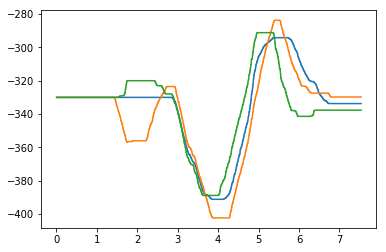

In [24]:
from matplotlib import pyplot as plt
plt.plot(T,top, label = 'top')
plt.plot(T,middle, label='middle')
plt.plot(T,bottom, label = 'bottom')

In [27]:
r.disk_bottom.compliant = False
r.disk_middle.compliant = False
r.disk_top.compliant = False

for i in range(len(move)):
    r.disk_top.target_rot_position = move[i][0]
    r.disk_middle.target_rot_position = move[i][1]
    r.disk_bottom.target_rot_position = move[i][2]
    time.sleep(0.005)